<a href="https://colab.research.google.com/github/thuvarahan97/ADL-AI-Summit-2021---AI-Vendors/blob/main/RentalPlan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries and Dataset**

In [946]:
# pip install catboost

In [947]:
# load numpy
import numpy as np

# load pandas
import pandas as pd

# load matplot lib for various plotting
import matplotlib.pyplot as plt   
%matplotlib inline

# for visually appealing plots
import seaborn as sns

# to use the Logit()
import statsmodels.api as sm

# for cross validation
from sklearn.model_selection import train_test_split

# for preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler

# for various metrics and reporting
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# load classifiers
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold,train_test_split, KFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import Pool, CatBoostClassifier

# SMOTE
from imblearn.over_sampling import SMOTE

# ADASYN
from imblearn.over_sampling import ADASYN

# SMOTE+Tomek
from imblearn.combine import SMOTETomek

# SMOTE+ENN
from imblearn.combine import SMOTEENN

# others
import scipy
from scipy import stats
from scipy.stats.mstats import winsorize
import warnings
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from collections import Counter
from numpy import where

In [948]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [949]:
dir = '/content/drive/My Drive/Colab Notebooks/ADL AI Summit 2021/PreHackathon/'

In [950]:
# loading data files
train_set = pd.read_csv(dir + 'train_dataset.csv')
test_set = pd.read_csv(dir + 'test_dataset.csv')
submission = pd.read_csv(dir + 'sample_submission.csv')

In [951]:
# Train data
train_set.head()

,primary_identifier,device_type,device_category,gender,district_name,age_group,network_stay,average_monthly_bill_amount,dusage_sum,dusage_min,dusage_max,dusage_avg,dusage_days,dusage_stddev,vusage_onnet_sum,vusage_onnet_max,vusage_onnet_min,vusage_onnet_days,vusage_onnet_avg,vusage_onnet_stddev,vusage_offnet_sum,vusage_offnet_max,vusage_offnet_min,vusage_offnet_days,vusage_offnet_avg,vusage_offnet_stddev,number_of_fixed_bb_accounts,number_of_iptv_accounts,add_on_tot_rental,add_on_count,next_month_plan
0,6875768,4G,Smartphone,MALE,Kegalle,40-50,219,761.62,6317.0,2.773958,622.685848,210.579939,30.0,197.116822,0.0,0.0,0.0,0.0,NaN,0.0,677.0,152.866667,0.0,27.0,25.099383,34.759221,0.0,1.0,NaN,NaN,PKG2
1,6406277,4G,Smartphone,MALE,Galle,40-50,36,2482.52,28365.0,3.079438,2569.429138,945.531235,30.0,573.299639,0.0,0.0,0.0,0.0,NaN,0.0,76.0,35.433333,0.0,15.0,5.071111,6.779644,0.0,0.0,600.0,2.0,PKG1
2,3563570,4G,Smartphone,MALE,Kandy,30-40,186,1565.55,18581.0,48.193713,2739.515326,619.378810,30.0,619.750500,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.000000,0.0,0.0,NaN,0.000000,0.0,0.0,0.0,1.0,PKG6
3,1853666,4G,Smartphone,FEMALE,Colombo,40-50,24,2397.49,91071.0,22.437842,7523.355693,3035.708609,30.0,2174.203127,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.000000,0.0,0.0,NaN,0.000000,0.0,0.0,1110.0,2.0,PKG4
4,2794331,4G,Smartphone,FEMALE,Kandy,50-60,37,2501.75,19736.0,53.302092,1239.220170,657.889802,30.0,329.152516,0.0,0.0,0.0,0.0,NaN,0.0,258.0,87.616667,0.0,23.0,11.256522,16.224071,0.0,1.0,1350.0,2.0,PKG4


In [952]:
# Test data
test_set.head()

,primary_identifier,device_type,device_category,gender,district_name,age_group,network_stay,average_monthly_bill_amount,dusage_sum,dusage_min,dusage_max,dusage_avg,dusage_days,dusage_stddev,vusage_onnet_sum,vusage_onnet_max,vusage_onnet_min,vusage_onnet_days,vusage_onnet_avg,vusage_onnet_stddev,vusage_offnet_sum,vusage_offnet_max,vusage_offnet_min,vusage_offnet_days,vusage_offnet_avg,vusage_offnet_stddev,number_of_fixed_bb_accounts,number_of_iptv_accounts,add_on_tot_rental,add_on_count
0,2003793,4G,Smartphone,MALE,Colombo,40-50,4,689.42,148.0,0.000000,148.146634,37.037382,4.0,38.251243,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.000000,0.0,0.0,NaN,0.000000,0.0,1.0,NaN,NaN
1,1776101,4G,Smartphone,MALE,Colombo,40-50,7,799.93,300.0,0.180222,119.466825,10.027957,30.0,24.125172,0.0,0.0,0.0,0.0,NaN,0.0,107.0,16.266667,0.0,21.0,5.107143,4.924111,0.0,0.0,NaN,NaN
2,6945050,2G,Basic,MALE,Colombo,20-30,20,1538.45,8215.0,0.000000,4048.511104,2053.950266,4.0,932.358667,0.0,0.0,0.0,0.0,NaN,0.0,108.0,90.000000,0.0,8.0,13.558333,16.397071,0.0,0.0,110.0,2.0
3,2472049,4G,Smartphone,FEMALE,Matara,40-50,10,995.75,11613.0,0.000000,1057.448432,430.118721,27.0,268.457304,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.416667,0.0,2.0,0.333333,0.087355,0.0,0.0,NaN,NaN
4,7197266,4G,Smartphone,MALE,Kandy,30-40,154,553.61,26505.0,28.515345,2490.832742,883.505624,30.0,660.353290,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.000000,0.0,0.0,NaN,0.000000,0.0,0.0,350.0,1.0


In [953]:
train_set.shape

(10500, 31)

In [954]:
test_set.shape

(4500, 30)

In [955]:
train_set.describe()

,primary_identifier,network_stay,average_monthly_bill_amount,dusage_sum,dusage_min,dusage_max,dusage_avg,dusage_days,dusage_stddev,vusage_onnet_sum,vusage_onnet_max,vusage_onnet_min,vusage_onnet_days,vusage_onnet_avg,vusage_onnet_stddev,vusage_offnet_sum,vusage_offnet_max,vusage_offnet_min,vusage_offnet_days,vusage_offnet_avg,vusage_offnet_stddev,number_of_fixed_bb_accounts,number_of_iptv_accounts,add_on_tot_rental,add_on_count
count,1.050000e+04,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,9642.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.0,10500.000000,1828.000000,10500.000000,10500.000000,10500.000000,10500.000000,10500.000000,7187.000000,10500.000000,10500.000000,10500.000000,6667.000000,6667.000000
mean,5.531286e+06,91.984381,2083.923835,12813.022667,72.723046,1440.667844,492.631079,24.791524,330.034959,22.845524,6.044802,0.0,0.762095,18.225919,1.488175,67.660857,14.700308,0.024573,8.970667,6.559910,3.493543,0.052857,0.246762,518.560072,1.889156
std,2.597973e+06,71.888784,1470.550224,15873.353992,168.971572,1846.417470,552.332657,9.677004,403.594192,121.657675,23.327802,0.0,2.734213,22.107320,6.045622,130.195398,22.039382,0.360990,9.454676,7.527537,5.231989,0.236587,0.500846,622.863583,1.224138
min,1.000454e+06,3.000000,-11446.340000,0.000000,0.000000,0.000000,0.000042,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,0.000000,0.016667,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3.286428e+06,22.000000,1036.270000,1939.000000,0.000000,367.013343,123.664867,25.000000,89.722583,0.000000,0.000000,0.0,0.000000,3.479167,0.000000,0.000000,0.000000,0.000000,0.000000,2.397829,0.000000,0.000000,0.000000,200.000000,1.000000
50%,5.538684e+06,82.000000,1783.845000,7800.500000,2.385201,977.321670,328.181079,30.000000,232.348678,0.000000,0.000000,0.0,0.000000,9.277778,0.000000,17.000000,6.858333,0.000000,6.000000,4.419298,1.614136,0.000000,0.000000,360.000000,2.000000
75%,7.799776e+06,149.000000,2700.592500,17836.000000,64.012977,1840.254781,665.463278,30.000000,424.423794,0.000000,0.000000,0.0,0.000000,26.961806,0.000000,85.000000,21.087500,0.000000,16.000000,7.851111,5.016638,0.000000,0.000000,650.000000,2.000000
max,9.999195e+06,314.000000,19007.890000,176410.000000,3501.540916,30513.071629,7386.100749,30.000000,6913.568069,3009.000000,423.283333,0.0,29.000000,221.766667,122.293736,2642.000000,477.300000,25.566667,30.000000,107.998148,90.944793,3.000000,3.000000,19450.000000,24.000000


# **Preprocessing Dataset**

In [956]:
# Assign index to each dataset
train_set = train_set.set_index('primary_identifier')
test_set = test_set.set_index('primary_identifier')

In [957]:
train_set.columns

Index(['device_type', 'device_category', 'gender', 'district_name',
       'age_group', 'network_stay', 'average_monthly_bill_amount',
       'dusage_sum', 'dusage_min', 'dusage_max', 'dusage_avg', 'dusage_days',
       'dusage_stddev', 'vusage_onnet_sum', 'vusage_onnet_max',
       'vusage_onnet_min', 'vusage_onnet_days', 'vusage_onnet_avg',
       'vusage_onnet_stddev', 'vusage_offnet_sum', 'vusage_offnet_max',
       'vusage_offnet_min', 'vusage_offnet_days', 'vusage_offnet_avg',
       'vusage_offnet_stddev', 'number_of_fixed_bb_accounts',
       'number_of_iptv_accounts', 'add_on_tot_rental', 'add_on_count',
       'next_month_plan'],
      dtype='object')

Text(0.5, 1.0, 'Next Month Plan Classes vs. Count')

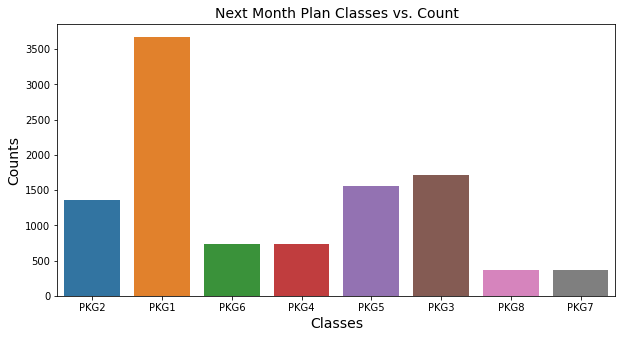

In [958]:
# Bar plot for counts in each class in Training data
plt.subplots(figsize=(10,5))
sns.countplot(x='next_month_plan', data=train_set)
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.title('Next Month Plan Classes vs. Count', fontsize=14)

### **Check features relationship**

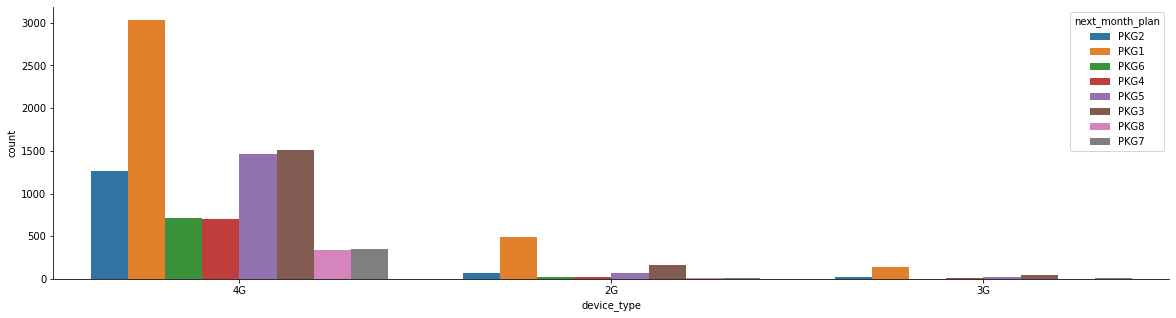

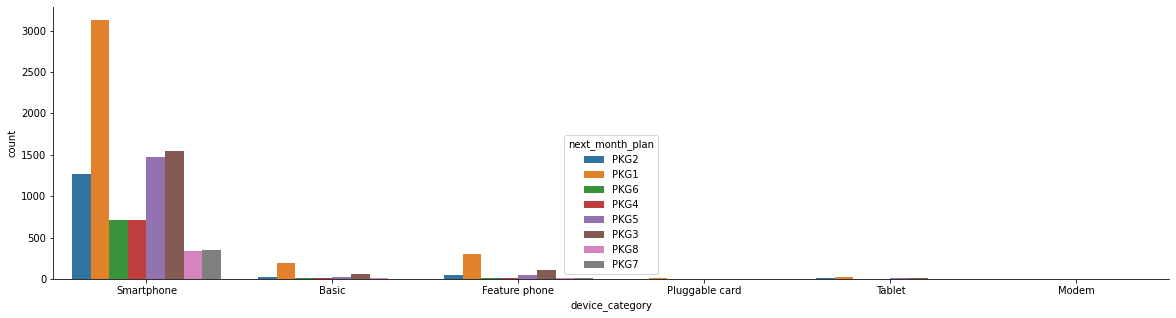

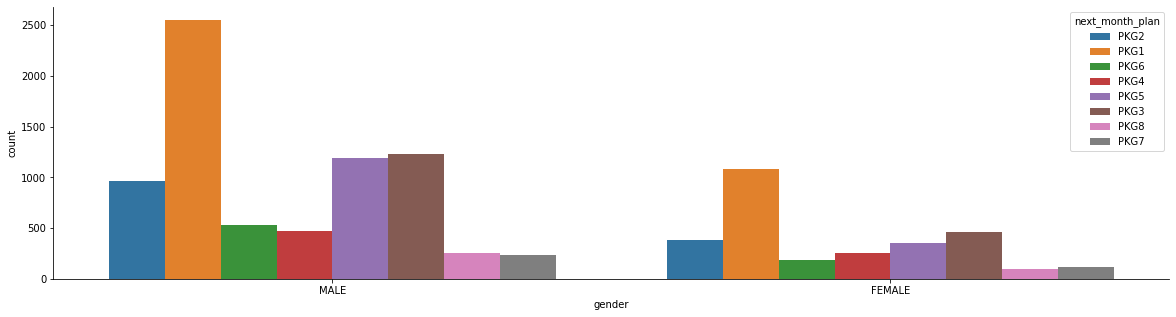

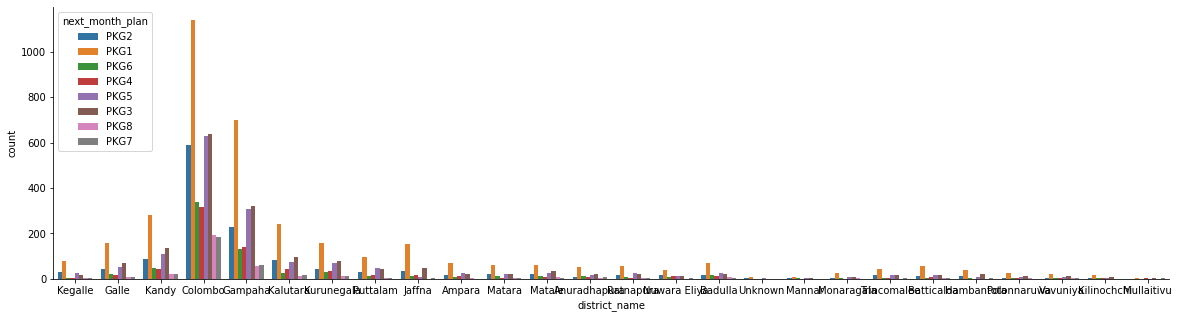

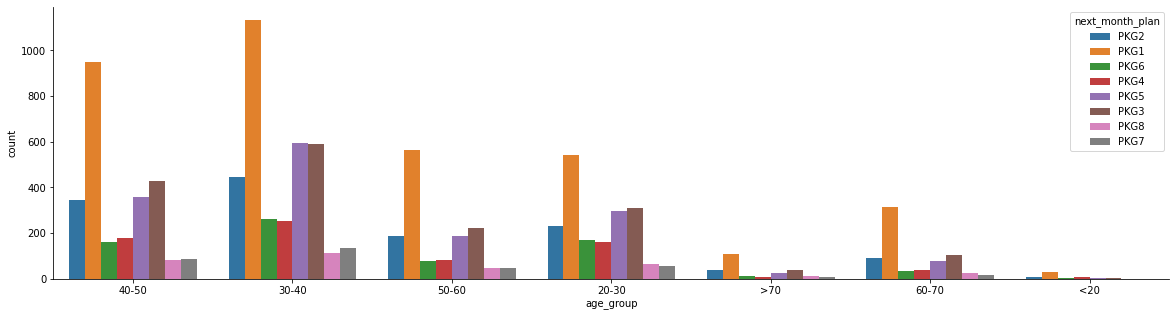

In [959]:
def plotDataGraph(x):
  temp = train_set.copy()
  fig, axs = plt.subplots(figsize=(20, 5))
  plot = sns.countplot(x=x, hue='next_month_plan', data=temp)
  sns.despine()


plot_cols=['device_type', 'device_category', 'gender', 'district_name', 'age_group']
for i in range(0, len(plot_cols)):
  plotDataGraph(plot_cols[i])

### **Handle missing data**

In [960]:
# Find the count of null values in train_data
train_set.isnull().sum()

device_type                      23
device_category                  30
gender                          135
district_name                     0
age_group                       135
network_stay                      0
average_monthly_bill_amount       0
dusage_sum                        0
dusage_min                        0
dusage_max                        0
dusage_avg                      858
dusage_days                       0
dusage_stddev                     0
vusage_onnet_sum                  0
vusage_onnet_max                  0
vusage_onnet_min                  0
vusage_onnet_days                 0
vusage_onnet_avg               8672
vusage_onnet_stddev               0
vusage_offnet_sum                 0
vusage_offnet_max                 0
vusage_offnet_min                 0
vusage_offnet_days                0
vusage_offnet_avg              3313
vusage_offnet_stddev              0
number_of_fixed_bb_accounts       0
number_of_iptv_accounts           0
add_on_tot_rental           

In [961]:
# Find the count of null values in test_data
test_set.isnull().sum()

device_type                      13
device_category                  16
gender                           55
district_name                     0
age_group                        55
network_stay                      0
average_monthly_bill_amount       0
dusage_sum                        0
dusage_min                        0
dusage_max                        0
dusage_avg                      364
dusage_days                       0
dusage_stddev                     0
vusage_onnet_sum                  0
vusage_onnet_max                  0
vusage_onnet_min                  0
vusage_onnet_days                 0
vusage_onnet_avg               3715
vusage_onnet_stddev               0
vusage_offnet_sum                 0
vusage_offnet_max                 0
vusage_offnet_min                 0
vusage_offnet_days                0
vusage_offnet_avg              1426
vusage_offnet_stddev              0
number_of_fixed_bb_accounts       0
number_of_iptv_accounts           0
add_on_tot_rental           

In [962]:
# Find the missing data
def findMissingData(data, title):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    missingdata=pd.concat([total, percent], axis=1, keys=['Total', 'Percentage'])
    missingdata= missingdata[missingdata["Percentage"] > 0]

    plt.subplots(figsize=(15,5))
    sns.barplot(missingdata.index, missingdata["Percentage"])
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.title('Feature vs. Percentage of missing data in ' + title, fontsize=14)
    
    return missingdata

Missing values in Train Data
Missing values in Test Data


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,Total,Percentage
vusage_onnet_avg,3715,82.555556
add_on_count,1712,38.044444
add_on_tot_rental,1712,38.044444
vusage_offnet_avg,1426,31.688889
dusage_avg,364,8.088889
gender,55,1.222222
age_group,55,1.222222
device_category,16,0.355556
device_type,13,0.288889


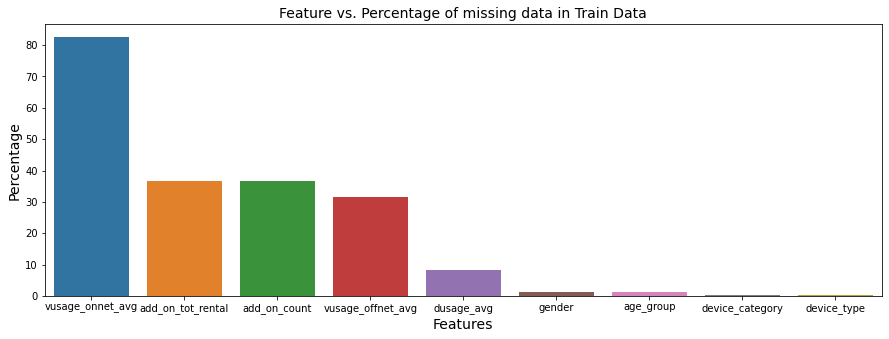

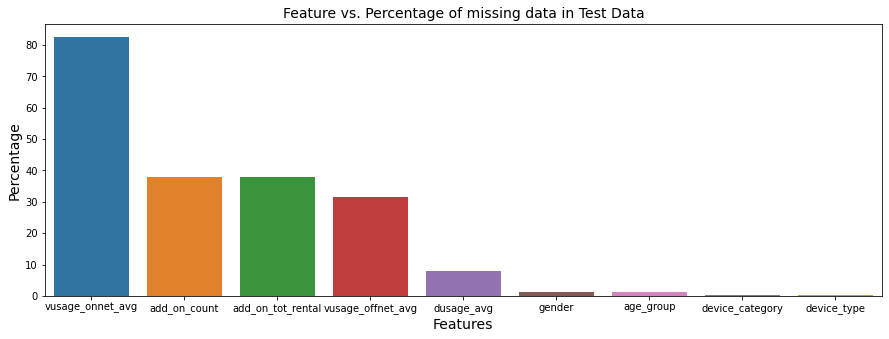

In [963]:
# Show missing values in train_data
print("Missing values in Train Data")
findMissingData(train_set, "Train Data")

# Show missing values in test_data
print("Missing values in Test Data")
findMissingData(test_set, "Test Data")

In [964]:
# transform_cols = ['device_category', 'device_type', 'district_name', 'gender', 'age_group']
# # transform_cols = ['device_type', 'district_name', 'gender', 'age_group']

# for x in range(len(transform_cols)):
#   train_set[transform_cols[x]] = LabelEncoder().fit_transform(train_set[transform_cols[x]].astype(str).str.strip())
#   test_set[transform_cols[x]] = LabelEncoder().fit_transform(test_set[transform_cols[x]].astype(str).str.strip())

In [965]:
# Drop "scheme_name" column in train_set and test_set
train_set.drop(['vusage_onnet_avg'], axis=1, inplace = True)
test_set.drop(['vusage_onnet_avg'], axis=1, inplace=True)

In [966]:
train_set['add_on_count'].fillna(train_set['add_on_count'].mode()[0], inplace = True)
test_set['add_on_count'].fillna(test_set['add_on_count'].mode()[0], inplace = True)

train_set['add_on_tot_rental'].fillna(train_set['add_on_tot_rental'].mode()[0], inplace = True)
test_set['add_on_tot_rental'].fillna(test_set['add_on_tot_rental'].mode()[0], inplace = True)

train_set['vusage_offnet_avg'].fillna(train_set['vusage_offnet_avg'].mean(), inplace = True)
test_set['vusage_offnet_avg'].fillna(test_set['vusage_offnet_avg'].mean(), inplace = True)

train_set['dusage_avg'].fillna(train_set['dusage_avg'].mean(), inplace = True)
test_set['dusage_avg'].fillna(test_set['dusage_avg'].mean(), inplace = True)

train_set['age_group'].fillna(train_set['age_group'].mode()[0], inplace = True)
test_set['age_group'].fillna(test_set['age_group'].mode()[0], inplace = True)

train_set['gender'].fillna(train_set['gender'].mode()[0], inplace = True)
test_set['gender'].fillna(test_set['gender'].mode()[0], inplace = True)

train_set['device_category'].fillna(train_set['device_category'].mode()[0], inplace = True)
test_set['device_category'].fillna(test_set['device_category'].mode()[0], inplace = True)

train_set['device_type'].fillna(train_set['device_type'].mode()[0], inplace = True)
test_set['device_type'].fillna(test_set['device_type'].mode()[0], inplace = True)

### **Correlation Analysis**

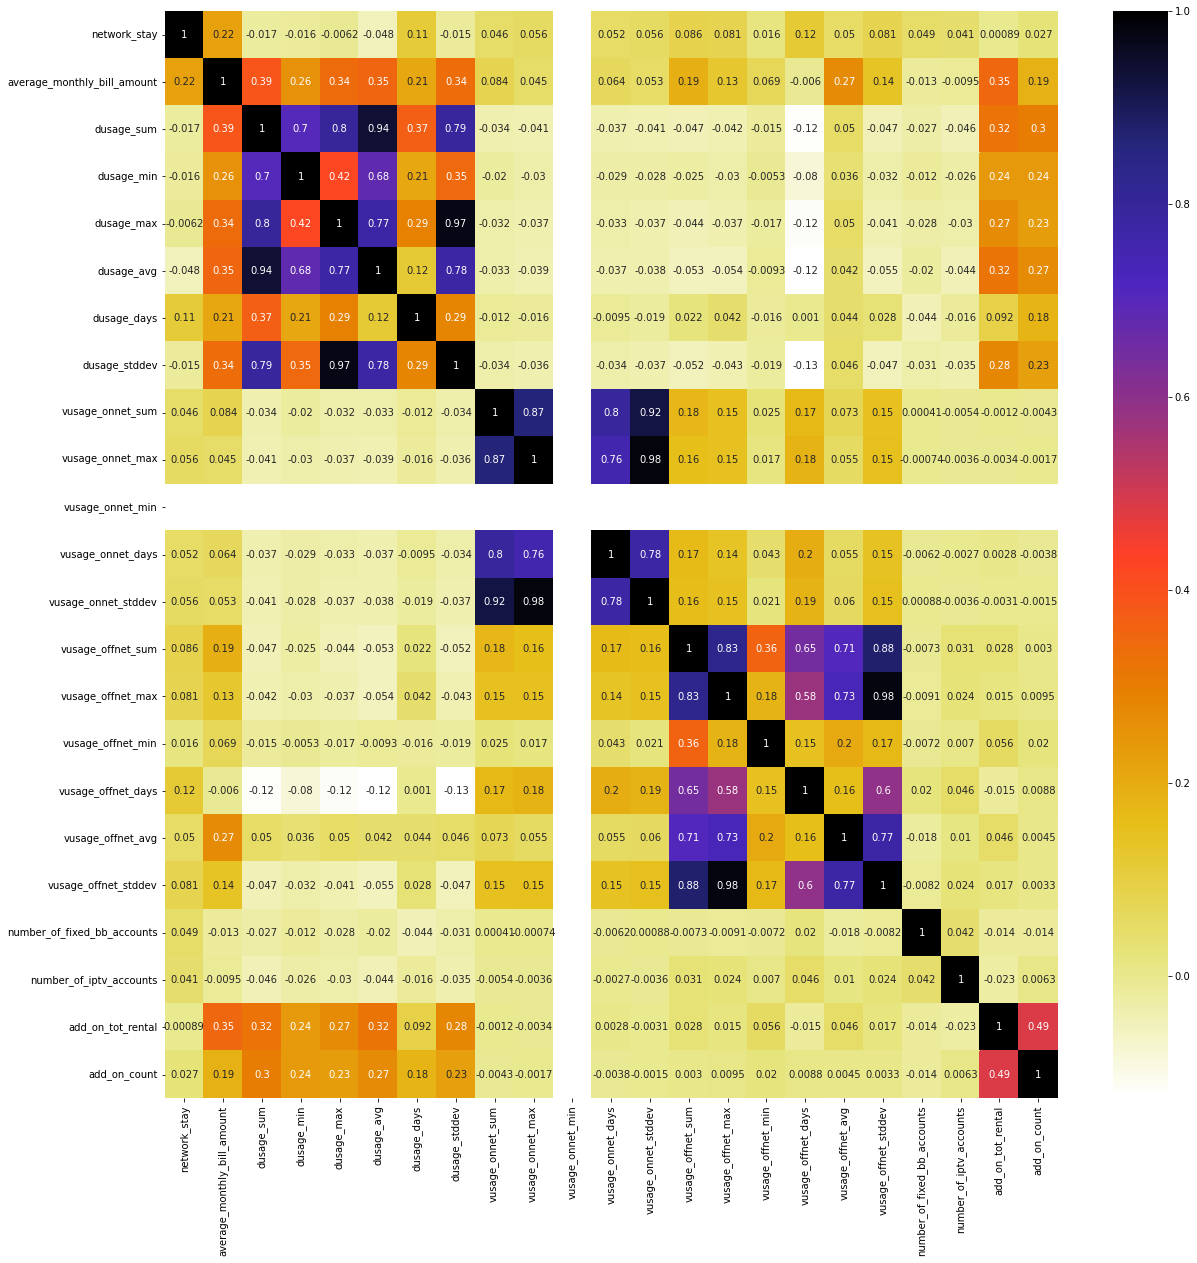

In [967]:
temp_data = train_set.copy()
temp_data.drop('next_month_plan', axis=1, inplace=True)

# using Pearson Correlation
plt.figure(figsize=(20,20))
cor = temp_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [968]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [969]:
corr_features = correlation(temp_data, 0.85)
len(set(corr_features))

5

In [970]:
corr_features

{'dusage_avg',
 'dusage_stddev',
 'vusage_offnet_stddev',
 'vusage_onnet_max',
 'vusage_onnet_stddev'}

In [971]:
train_set.drop(corr_features, axis=1, inplace = True)
test_set.drop(corr_features, axis=1, inplace = True)

### **Label encoding**

In [972]:
# label encode next_month_plan column
next_month_plan = {'PKG1':1,'PKG2':2,'PKG3':3,'PKG4':4,'PKG5':5,'PKG6':6,'PKG7':7,'PKG8':8}
train_set['next_month_plan'] = train_set['next_month_plan'].map(next_month_plan)
pd.to_numeric(train_set['next_month_plan'])
train_set['next_month_plan'] = train_set['next_month_plan'].astype(int)

In [973]:
# Combine train_set and test_set
all_data = pd.concat([train_set, test_set], axis=0, sort=False)

In [974]:
# label encode age_group column
age_group = {'<20':1,'20-30':2,'30-40':3,'40-50':4,'50-60':5,'60-70':6,'>70':7}
all_data['age_group'] = all_data['age_group'].map(age_group)
pd.to_numeric(all_data['age_group'])
all_data['age_group'] = all_data['age_group'].astype(int)

In [975]:
# label encode gender column
gender = {'FEMALE':0,'MALE':1}
all_data['gender'] = all_data['gender'].map(gender)
pd.to_numeric(all_data['gender'])
all_data['gender'] = all_data['gender'].astype(int)

In [976]:
# label encode device_type column
device_type = {'2G':0,'3G':1,'4G':2}
all_data['device_type'] = all_data['device_type'].map(device_type)
pd.to_numeric(all_data['device_type'])
all_data['device_type'] = all_data['device_type'].astype(int)

In [977]:
# display all device_category counts
all_data['device_category'].value_counts()

Smartphone        13654
Feature phone       787
Basic               451
Tablet               84
Modem                13
Pluggable card       10
M2M                   1
Name: device_category, dtype: int64

In [978]:
# replace device_category values that are not in defined arr_device_category list with 'Other'
arr_device_category = ['Basic','Modem','Pluggable card','Feature phone','Tablet','Smartphone']
all_data.loc[~all_data['device_category'].isin(arr_device_category), 'device_category'] = 'Other'

In [979]:
# label encode device_category column
device_category = {'Basic':0,'Modem':1,'Pluggable card':2,'Feature phone':3,'Tablet':4,'Smartphone':5, 'Other':6}
all_data['device_category'] = all_data['device_category'].map(device_category)
pd.to_numeric(all_data['device_category'])
all_data['device_category'] = all_data['device_category'].astype(int)

In [980]:
# replace 'Unknown' values in district_name with mode value
all_data['district_name'] = all_data['district_name'].replace('Unknown', all_data['district_name'].mode()[0])

In [981]:
# label encode district_name column
all_data['district_name'] = LabelEncoder().fit_transform(all_data['district_name'])

### **Remove outliers**

In [982]:
# replace negative values in average_monthly_bill_amount with mean value
# all_data['average_monthly_bill_amount'] = np.where(all_data['average_monthly_bill_amount'] <= 0, np.NaN, all_data['average_monthly_bill_amount'])
# all_data['average_monthly_bill_amount'].fillna(all_data['average_monthly_bill_amount'].mean(), inplace = True)
# all_data["average_monthly_bill_amount"] = all_data.groupby("region_code")['average_monthly_bill_amount'].apply(lambda x: x.fillna(x.mean()))

In [983]:
# # take absolute value for average_monthly_bill_amount
# all_data['average_monthly_bill_amount'] = all_data['average_monthly_bill_amount'].abs()

In [984]:
# fig, ax = plt.subplots(figsize=(16,10))
# ax.scatter(all_data['device_type'], all_data['average_monthly_bill_amount'])
# ax.set_xlabel('Proportion of non-retail business acres per town')
# ax.set_ylabel('Full-value property-tax rate per $10,000')
# plt.show()

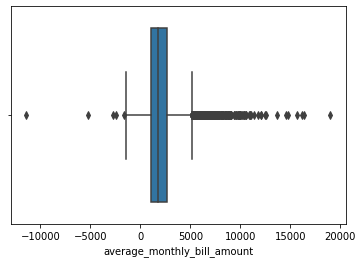

In [985]:
sns.boxplot(x = all_data['average_monthly_bill_amount'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


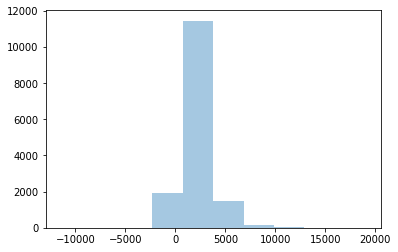

In [986]:
sns.distplot(x = all_data['average_monthly_bill_amount'], bins=10, kde=False)
plt.show()

In [987]:
all_data['average_monthly_bill_amount'].describe()

count    15000.000000
mean      2077.708651
std       1454.166636
min     -11446.340000
25%       1033.015000
50%       1785.670000
75%       2690.587500
max      19007.890000
Name: average_monthly_bill_amount, dtype: float64

In [988]:
all_data['average_monthly_bill_amount'].quantile(0.01685)

400.0565475

In [989]:
all_data['average_monthly_bill_amount'].quantile(0.98)

6139.408000000001

In [990]:
Q1 = all_data['average_monthly_bill_amount'].quantile(0.25)
Q3 = all_data['average_monthly_bill_amount'].quantile(0.75)
IQR = Q3 - Q1

In [991]:
IQR

1657.5725000000002

In [992]:
lower_lim = Q1 - 1.5 * IQR
upper_lim = Q3 + 1.5 * IQR

In [993]:
lower_lim

-1453.3437500000005

In [994]:
upper_lim

5176.946250000001

In [995]:
all_data['average_monthly_bill_amount'] = winsorize(all_data['average_monthly_bill_amount'], (0.0169, 0.02))

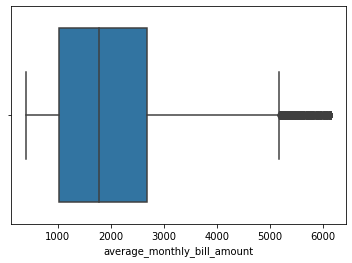

In [996]:
sns.boxplot(x = all_data['average_monthly_bill_amount'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


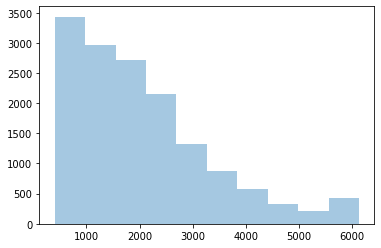

In [997]:
sns.distplot(x = all_data['average_monthly_bill_amount'], bins=10, kde=False)
plt.show()

In [998]:
all_data['average_monthly_bill_amount'] = pd.DataFrame(all_data['average_monthly_bill_amount'])

In [999]:
all_data['average_monthly_bill_amount'].describe()

count    15000.000000
mean      2053.736981
std       1311.464537
min        400.230000
25%       1033.015000
50%       1785.670000
75%       2690.587500
max       6139.380000
Name: average_monthly_bill_amount, dtype: float64

### **Other outliers**

In [1000]:
# f, axes = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')
# sns.boxplot(x = all_data['average_monthly_bill_amount'], ax=axes[0,0])
# sns.distplot(x = all_data['average_monthly_bill_amount'], bins=10, kde=False, ax=axes[0,1])

In [1001]:
# all_data['average_monthly_bill_amount'].describe()

In [1002]:
# all_data['average_monthly_bill_amount'].quantile(0.01685)

In [1003]:
# all_data['average_monthly_bill_amount'].quantile(0.98)

In [1004]:
# all_data['average_monthly_bill_amount'] = winsorize(all_data['average_monthly_bill_amount'], (0.0169, 0.02))

In [1005]:
# f, axes = plt.subplots(1, 1, figsize=(20, 10), facecolor='white')
# sns.boxplot(x = all_data['average_monthly_bill_amount'], ax=axes[0,0])
# sns.distplot(x = all_data['average_monthly_bill_amount'], bins=10, kde=False, ax=axes[0,1])

### **Create new columns**

In [1006]:
# data usage in GB
all_data['dusage_sum'] = all_data['dusage_sum'].div(1024.0).round(2)

In [1007]:
# all_data['average_monthly_bill_amount'] = pd.cut(all_data['average_monthly_bill_amount'], bins=4)

In [1008]:
# # average_monthly_bill_amount to categorical
# all_data.loc[ all_data['average_monthly_bill_amount'] <= 400 , 'average_monthly_bill_amount'] = 0
# all_data.loc[(all_data['average_monthly_bill_amount'] > 400) & (all_data['average_monthly_bill_amount'] <= 620), 'average_monthly_bill_amount'] = 1
# all_data.loc[(all_data['average_monthly_bill_amount'] > 620) & (all_data['average_monthly_bill_amount'] <= 950), 'average_monthly_bill_amount'] = 2
# all_data.loc[(all_data['average_monthly_bill_amount'] > 950) & (all_data['average_monthly_bill_amount'] <= 1300), 'average_monthly_bill_amount'] = 3
# all_data.loc[(all_data['average_monthly_bill_amount'] > 1300) & (all_data['average_monthly_bill_amount'] <= 1550), 'average_monthly_bill_amount'] = 4
# all_data.loc[(all_data['average_monthly_bill_amount'] > 1550) & (all_data['average_monthly_bill_amount'] <= 1900), 'average_monthly_bill_amount'] = 5
# all_data.loc[(all_data['average_monthly_bill_amount'] > 1900) & (all_data['average_monthly_bill_amount'] <= 2550), 'average_monthly_bill_amount'] = 6
# all_data.loc[(all_data['average_monthly_bill_amount'] > 2550) & (all_data['average_monthly_bill_amount'] <= 3200), 'average_monthly_bill_amount'] = 7
# all_data.loc[all_data['average_monthly_bill_amount'] > 3200, 'average_monthly_bill_amount'] = 8

# pd.to_numeric(train_set['average_monthly_bill_amount'])
# all_data['average_monthly_bill_amount'] = all_data['average_monthly_bill_amount'].astype(int)

In [1009]:
all_data['average_monthly_bill_amount'] = all_data['average_monthly_bill_amount'].astype(int)

In [1010]:
# dusage_sum to categorical
all_data.loc[ all_data['dusage_sum'] <= 3 , 'dusage_sum'] = 1
all_data.loc[(all_data['dusage_sum'] > 3) & (all_data['dusage_sum'] <= 6), 'dusage_sum'] = 2
all_data.loc[(all_data['dusage_sum'] > 6) & (all_data['dusage_sum'] <= 8), 'dusage_sum'] = 3
all_data.loc[(all_data['dusage_sum'] > 8) & (all_data['dusage_sum'] <= 12), 'dusage_sum'] = 4
all_data.loc[(all_data['dusage_sum'] > 12) & (all_data['dusage_sum'] <= 20), 'dusage_sum'] = 5
all_data.loc[(all_data['dusage_sum'] > 20) & (all_data['dusage_sum'] <= 40), 'dusage_sum'] = 6
all_data.loc[(all_data['dusage_sum'] > 40) & (all_data['dusage_sum'] <= 50), 'dusage_sum'] = 7
all_data.loc[all_data['dusage_sum'] > 50, 'dusage_sum'] = 8

pd.to_numeric(train_set['dusage_sum'])
all_data['dusage_sum'] = all_data['dusage_sum'].astype(int)

In [1011]:
all_data['vusage_onnet_sum'] = pd.cut(all_data['vusage_onnet_sum'], bins=10)

In [1012]:
all_data['vusage_offnet_sum'] = pd.cut(all_data['vusage_offnet_sum'], bins=10)

In [1013]:
# label encode vusage
all_data['vusage_onnet_sum'] = LabelEncoder().fit_transform(all_data['vusage_onnet_sum']) 
all_data['vusage_offnet_sum'] = LabelEncoder().fit_transform(all_data['vusage_offnet_sum']) 

### **Drop unimportant columns**

In [1014]:
all_data.columns

Index(['device_type', 'device_category', 'gender', 'district_name',
       'age_group', 'network_stay', 'average_monthly_bill_amount',
       'dusage_sum', 'dusage_min', 'dusage_max', 'dusage_days',
       'vusage_onnet_sum', 'vusage_onnet_min', 'vusage_onnet_days',
       'vusage_offnet_sum', 'vusage_offnet_max', 'vusage_offnet_min',
       'vusage_offnet_days', 'vusage_offnet_avg',
       'number_of_fixed_bb_accounts', 'number_of_iptv_accounts',
       'add_on_tot_rental', 'add_on_count', 'next_month_plan'],
      dtype='object')

In [1015]:
# # drop unimportant columns from train and test data
# to_drop = ['dusage_min', 'dusage_max', 'dusage_avg', 'dusage_days', 'dusage_stddev', 
#            'vusage_onnet_min', 'vusage_onnet_max', 'vusage_onnet_days', 'vusage_onnet_stddev',
#            'vusage_offnet_min', 'vusage_offnet_max', 'vusage_offnet_days', 'vusage_offnet_avg', 'vusage_offnet_stddev'
#            ]

# all_data.drop(to_drop, axis=1, inplace=True)

### **Perform One-Hot Encoding**

In [1016]:
# perform One-Hot Encoding
# dummies_cols=['gender','device_type', 'device_category']
dummies_cols=['gender']
all_data = pd.get_dummies(all_data, columns=dummies_cols)

### **Split train data for evaluation**

In [1017]:
# seperate the combined train and test data
train_set, test_set = all_data.loc[train_set.index], all_data.loc[test_set.index]

In [1018]:
X_train = train_set.drop('next_month_plan',axis=1)
y_train = train_set['next_month_plan']

In [1019]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

In [1020]:
train_columns = X_train.columns

In [1021]:
train_columns

Index(['device_type', 'device_category', 'district_name', 'age_group',
       'network_stay', 'average_monthly_bill_amount', 'dusage_sum',
       'dusage_min', 'dusage_max', 'dusage_days', 'vusage_onnet_sum',
       'vusage_onnet_min', 'vusage_onnet_days', 'vusage_offnet_sum',
       'vusage_offnet_max', 'vusage_offnet_min', 'vusage_offnet_days',
       'vusage_offnet_avg', 'number_of_fixed_bb_accounts',
       'number_of_iptv_accounts', 'add_on_tot_rental', 'add_on_count',
       'gender_0', 'gender_1'],
      dtype='object')

### **Handle unbalanced train data**

In [1022]:
# # using SMOTE for unbalanced train dataset
# counter = Counter(y_train)
# print ("Before", counter)
# smt = SMOTE()
# X_train_os, y_train = smt.fit_sample(X_train, y_train)
# counter = Counter(y_train)
# print ("After", counter)

In [1023]:
# # using ADASYN for unbalanced train dataset
# counter = Counter(y_train)
# print ("Before", counter)
# ada = ADASYN()
# X_train_os, y_train = ada.fit_sample(X_train, y_train)
# counter = Counter(y_train)
# print ("After", counter)

In [1024]:
# using SMOTE+Tomek for unbalanced train dataset
counter = Counter(y_train)
print ("Before", counter)
smtmk = SMOTETomek()
X_train_os, y_train = smtmk.fit_sample(X_train, y_train)
counter = Counter(y_train)
print ("After", counter)

Before Counter({1.0: 2907, 3.0: 1393, 5.0: 1237, 2.0: 1079, 4.0: 605, 6.0: 600, 7.0: 298, 8.0: 281})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

After Counter({8.0: 2847, 7.0: 2840, 6.0: 2806, 4.0: 2771, 5.0: 2751, 2.0: 2731, 3.0: 2695, 1.0: 2619})


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [1025]:
# # using SMOTE+ENN for unbalanced train dataset
# counter = Counter(y_train)
# print ("Before", counter)
# smtenn = SMOTEENN()
# X_train_os, y_train = smtenn.fit_sample(X_train, y_train)
# counter = Counter(y_train)
# print ("After", counter)

In [1026]:
# # scatter plot of examples by class label
# plt.subplots(figsize=(8,5))
# for label, _ in counter.items():
#   row_ix = where(y_train == label)[0]
#   pyplot.scatter(X_train[row_ix, 0], X_train[row_ix, 1], label=str(label))
# plt.legend()
# plt.show()

In [1027]:
# Retain train columns after oversampling
X_train = pd.DataFrame(X_train_os, columns=X_train.columns)

In [1028]:
# X_train = StandardScaler().fit_transform(X_train)
# X_test = StandardScaler().fit_transform(X_test)

In [1029]:
# X_train.head()

In [1030]:
# y_train.head()

# **Model Training**

In [1031]:
# Decision Tree Classifier
modelDTC = DecisionTreeClassifier(
    criterion='gini', 
    max_depth=10,
    min_samples_leaf=1, 
    min_samples_split=2
    )

# fit the DTC model on the training dataset
modelDTC.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [1032]:
# Random Forest Classifier
modelRFC = RandomForestClassifier(bootstrap=True,
                                  criterion='gini',
                                  min_impurity_decrease=0.0,
                                  min_samples_leaf=1,
                                  min_samples_split=2,
                                  n_estimators=1000,
                                  n_jobs=1,
                                  oob_score=True,
                                  random_state=0
                                  )

# fit the RFC model on the training dataset
modelRFC.fit(X_train, y_train)

print("OOB Score: %.4f" % modelRFC.oob_score_)

OOB Score: 0.8546


In [1033]:
# creating XGBoost classifier model object
modelXGB = XGBClassifier(learning_rate=0.05,
                         n_estimators=1000,
                         max_depth=3,
                         min_child_weight=5,
                         reg_alpha=0.005,
                         nthread=2,
                         colsample_bytree=0.8,
                         )

# fit the XGBoost model on the training dataset
modelXGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=3,
              min_child_weight=5, missing=None, n_estimators=1000, n_jobs=1,
              nthread=2, objective='multi:softprob', random_state=0,
              reg_alpha=0.005, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [1034]:
# LightGBM Classifier
modelLGBM = LGBMClassifier(num_boost_round=500,
                          learning_rate=0.1,
                          max_depth=15,
                          num_leaves=32,
                          feature_fraction=0.8,
                          subsample=0.2
                          )

# fit the LightGBM model on the train data
modelLGBM.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.8, importance_type='split', learning_rate=0.1,
               max_depth=15, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1,
               num_boost_round=500, num_leaves=32, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=0.2, subsample_for_bin=200000, subsample_freq=0)

In [1035]:
# # Cat Boost Classifier
# modelCBC = CatBoostClassifier(iterations=1000,
#                               random_state=0,
#                               max_depth=3,
#                               reg_lambda=30,
#                               max_ctr_complexity=5,
#                               eval_metric='AUC',
#                               task_type='CPU',
#                               od_type='Iter',
#                               od_wait=500
#                               )

# # fit the CBC model on the training dataset
# # modelCBC.fit(X_train, y_train, verbose=1000, eval_set=[(X_train,y_train),(X_test,y_test)], use_best_model=True, cat_features=categorical)
# modelCBC.fit(X_train, y_train, verbose=1000)

In [1036]:
# # SVM
# modelSVM = SVC(C=1.0,
#                kernel='rbf', 
#                degree=3,
#                coef0=0.0,
#                tol=0.001,
#                random_state=1)

# modelSVM.fit(X_train, y_train)

In [1037]:
# Function to display order of important features in a chart
def displayImportantFeatures(model, modelName):
    importances = pd.DataFrame(model.feature_importances_, index = X_train.columns)
    importances.sort_values(by = 0, inplace=True, ascending = False)
    importances = importances
    plt.figure(figsize=(10, 15)) 
    sns.barplot(x=0, y=importances.index, data=importances,palette="deep").set_title("Feature Importances for "+ modelName);
    sns.despine()

Model is not fit!


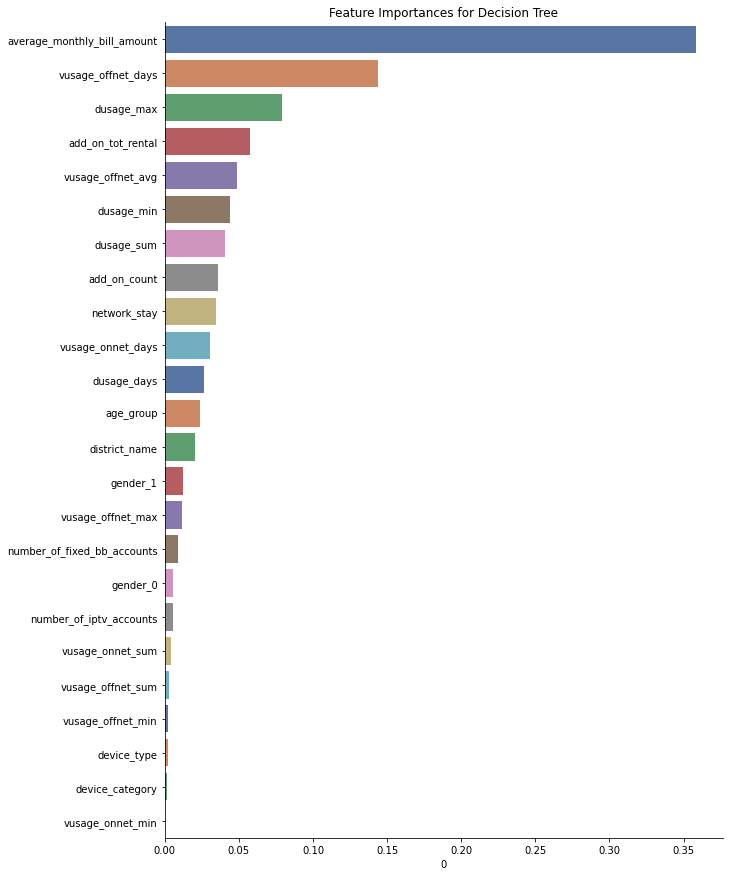

In [1038]:
try:
  displayImportantFeatures(modelDTC, "Decision Tree")
except NameError:
    print("Model is not defined!")
else:
  print("Model is not fit!")

Model is not fit!


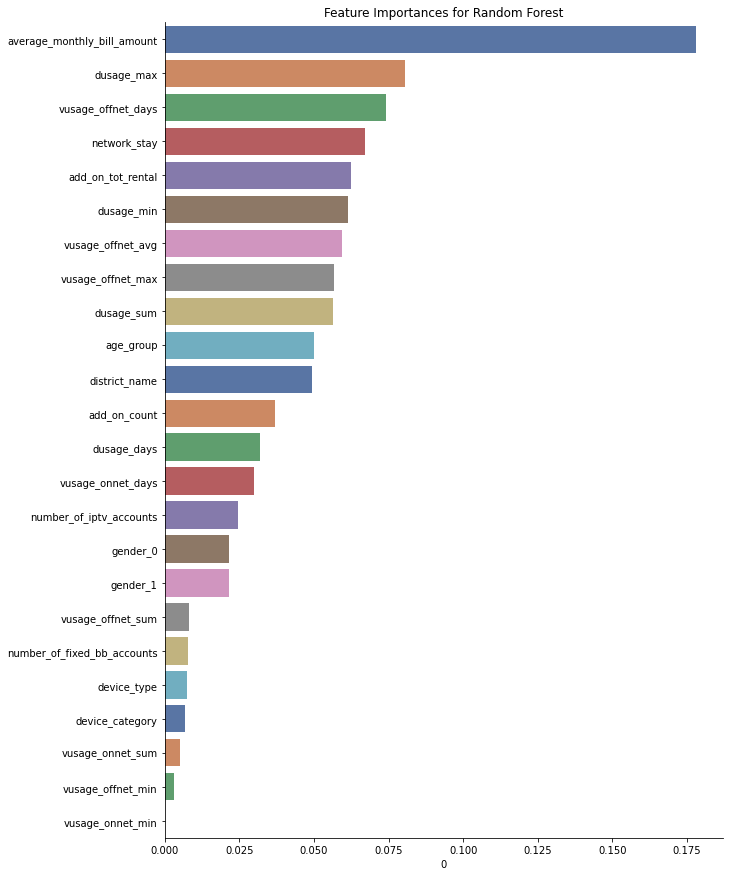

In [1039]:
try:
  displayImportantFeatures(modelRFC, "Random Forest")
except NameError:
    print("Model is not defined!")
else:
  print("Model is not fit!")

Model is not fit!


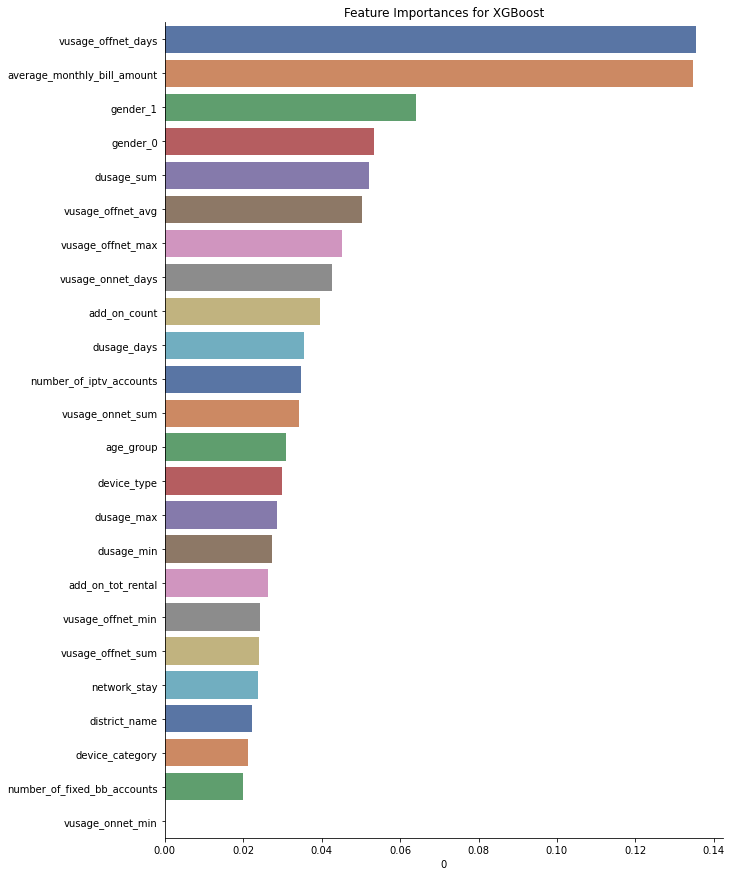

In [1040]:
try:
  displayImportantFeatures(modelXGB, "XGBoost")
except NameError:
    print("Model is not defined!")
else:
  print("Model is not fit!")

Model is not fit!


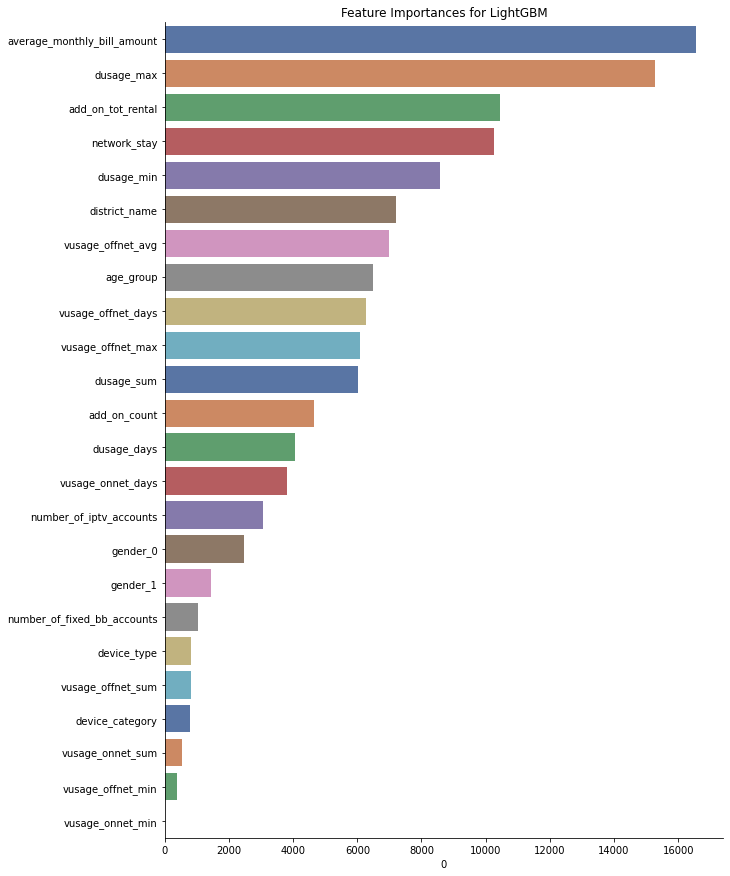

In [1041]:
try:
  displayImportantFeatures(modelLGBM, "LightGBM")
except NameError:
    print("Model is not defined!")
else:
  print("Model is not fit!")

In [1042]:

try:
  displayImportantFeatures(modelCBC, "Cat Boost")
except NameError:
    print("Model is not defined!")
else:
  print("Model is not fit!")

Model is not defined!


In [1043]:
# try:
#   displayImportantFeatures(modelSVM, "Cat Boost")
# except NameError:
#     print("Model is not defined!")
# else:
#   print("Model is not fit!")

# **Model Predictions**

### **Predictions for split test data**

In [1044]:
def calcScore(model, modelName):
  try:
    print ("Score calculated for " + modelName + "\n")

    # make probability predictions with the model for held out test data
    y_test_pred = model.predict(X_test)

    # Confusion matrix for held out test data
    confusionmatrix = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(confusionmatrix, annot=True, cmap="Greys", fmt="d", 
                xticklabels = ['PKG1', 'PKG2', 'PKG3', 'PKG4', 'PKG5', 'PKG6', 'PKG7', 'PKG8'], 
                yticklabels = ['PKG1', 'PKG2', 'PKG3', 'PKG4', 'PKG5', 'PKG6', 'PKG7', 'PKG8'])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("Confusion Matrix - " + modelName);
    
    # Classification report for held out test data
    print(classification_report(y_test, y_test_pred))
  except NameError:
    print("Data set was not splitted!")

Score calculated for Decision Tree

              precision    recall  f1-score   support

         1.0       0.79      0.60      0.68       766
         2.0       0.27      0.26      0.27       275
         3.0       0.42      0.57      0.48       324
         4.0       0.16      0.24      0.19       130
         5.0       0.67      0.57      0.62       321
         6.0       0.32      0.32      0.32       140
         7.0       0.19      0.32      0.23        66
         8.0       0.30      0.40      0.34        78

    accuracy                           0.49      2100
   macro avg       0.39      0.41      0.39      2100
weighted avg       0.54      0.49      0.51      2100

Model is not fit!


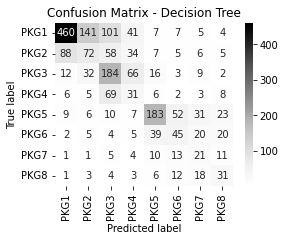

In [1045]:
try:
  calcScore(modelDTC, "Decision Tree")
except NameError:
    print("Model is not defined!")
else:
  print("Model is not fit!")

Score calculated for Random Forest

              precision    recall  f1-score   support

         1.0       0.74      0.74      0.74       766
         2.0       0.31      0.16      0.21       275
         3.0       0.45      0.61      0.52       324
         4.0       0.26      0.26      0.26       130
         5.0       0.63      0.64      0.63       321
         6.0       0.34      0.35      0.35       140
         7.0       0.23      0.18      0.20        66
         8.0       0.41      0.47      0.44        78

    accuracy                           0.55      2100
   macro avg       0.42      0.43      0.42      2100
weighted avg       0.54      0.55      0.54      2100

Not fit model!


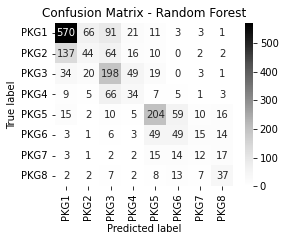

In [1046]:
try:
  calcScore(modelRFC, "Random Forest")
except NameError:
    print("Model is not defined!")
else:
  print("Not fit model!")

Score calculated for XGBoost

              precision    recall  f1-score   support

         1.0       0.74      0.79      0.76       766
         2.0       0.37      0.17      0.24       275
         3.0       0.48      0.60      0.53       324
         4.0       0.28      0.31      0.29       130
         5.0       0.67      0.60      0.63       321
         6.0       0.37      0.41      0.39       140
         7.0       0.19      0.23      0.21        66
         8.0       0.36      0.37      0.36        78

    accuracy                           0.56      2100
   macro avg       0.43      0.43      0.43      2100
weighted avg       0.55      0.56      0.55      2100

Model is not fit!


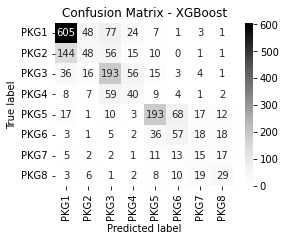

In [1047]:
try:
  calcScore(modelXGB, "XGBoost")
except NameError:
    print("Model is not defined!")
else:
  print("Model is not fit!")

Score calculated for LightGBM

              precision    recall  f1-score   support

         1.0       0.71      0.78      0.75       766
         2.0       0.33      0.19      0.24       275
         3.0       0.46      0.56      0.51       324
         4.0       0.25      0.24      0.24       130
         5.0       0.61      0.62      0.62       321
         6.0       0.31      0.31      0.31       140
         7.0       0.22      0.21      0.22        66
         8.0       0.35      0.29      0.32        78

    accuracy                           0.54      2100
   macro avg       0.41      0.40      0.40      2100
weighted avg       0.53      0.54      0.53      2100

Model is not fit!


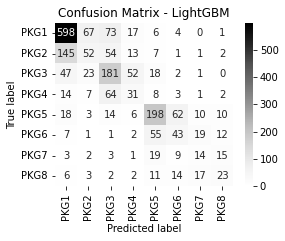

In [1048]:
try:
  calcScore(modelLGBM, "LightGBM")
except NameError:
    print("Model is not defined!")
else:
  print("Model is not fit!")

In [1049]:
try:
  calcScore(modelCBC, "Cat Boost")
except NameError:
    print("Model is not defined!")
else:
  print("Model is not fit!")

Model is not defined!


In [1050]:
# try:
#   calcScore(modelSVM, "SVM")
# except NameError:
#     print("Model is not defined!")
# else:
#   print("Model is not fit!")

### **Predictions for submission test data**

In [1051]:
model = modelRFC

In [1052]:
# Make predictions for test data
X_pred = test_set.drop('next_month_plan', axis=1)
# X_pred = StandardScaler().fit_transform(X_pred)
y_pred = model.predict(X_pred)

In [1053]:
# assign predicted values to submission
submission['next_month_plan'] = y_pred
pd.to_numeric(submission['next_month_plan'])
submission['next_month_plan'] = submission['next_month_plan'].astype(int)

# create csv from submission
submission.to_csv('submission.csv', index=False)

In [1054]:
# download submission file
from google.colab import files
# files.download('submission.csv')